In [1]:
import sys
sys.path.append('../..')
from datasets import load_dataset, load_dataset_builder

from astropile.utils import cross_match_datasets
from photo_z_wrapper import PhotoZWrapper

/mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-python-3.9.15-view/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /mnt/sw/nix/store/7bjp92vyxq4vmcm6q2kwdv325d50n362-py-torchvision-0.14.1/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Load Dataset Builders 
hsc_builder = load_dataset_builder('/mnt/ceph/users/polymathic/AstroPile_tiny/hsc/hsc.py', trust_remote_code=True)
desi_builder = load_dataset_builder('/mnt/ceph/users/polymathic/AstroPile_tiny/desi/desi.py', trust_remote_code=True)

# Cross-Match Datasets with AstroPile
hsc_meets_desi = cross_match_datasets(desi_builder, hsc_builder,
                                      matching_radius=1.0,
                                      keep_in_memory=True,
                                      )

hsc_meets_desi.set_format('torch')

/mnt/home/lparker/python_envs/astrokernel/lib/python3.9/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Initial number of matches:  1286
Number of matches lost at healpix region borders:  0
Final size of cross-matched catalog:  1286


In [3]:
sys.path.append('../')
from utils import split_dataset

# Use prebuilt split function to split the dataset (currently supports naive)
train_dataset, test_dataset = split_dataset(hsc_meets_desi, split='naive')

In [8]:
# Create PhotoZWrapper for training and testing
photo_z = PhotoZWrapper(
    train_dataset,
    test_dataset, 
    feature_flag='image.array', # feature flag
    label_flag='Z',             # label flag
    loading='iterated',         # iterated or full
    dynamic_range=True,         # arcsinh dynamic range compression
    batch_size=128, 
    num_workers=16, 
    test_size=0.2, 
    )    

In [9]:
# Prepare data before using the data loader
# This computes the statistics and sets up the collate functions correctly
photo_z.prepare_data()

Computing statistics for Z: 100%|██████████| 9/9 [00:01<00:00,  7.12it/s]


In [10]:
train_loader = photo_z.train_dataloader()
val_loader = photo_z.val_dataloader()
test_loader = photo_z.test_dataloader()

In [13]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([128, 5, 144, 144]), torch.Size([128]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


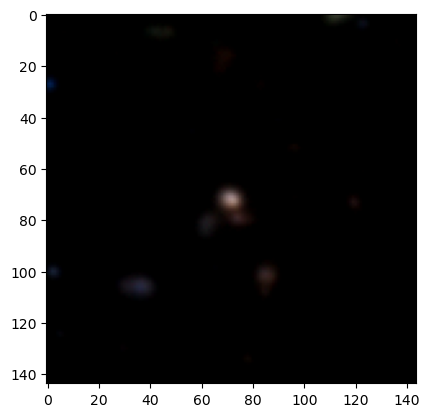

In [22]:
import matplotlib.pyplot as plt
plt.imshow(x[0,:3,:,:].T)